
Z-cut LN: TE mode use No,and TM mode use No
Total height : 600
bottom height: 100
top width : 600-2100nm, steps 100nm
side-wall angle: 70 degree
sio2 bottom cladding
Pulse: 10mW, 200MHz

- Propagation loss ?
- mode selection - TE or TM?

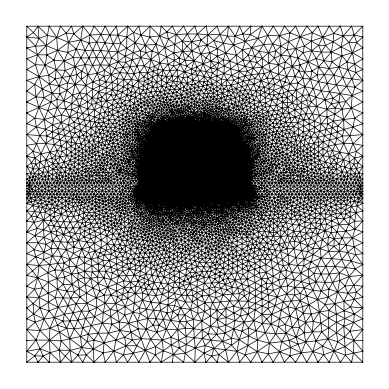

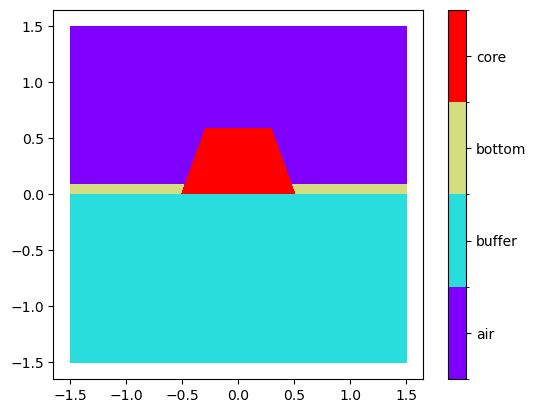

start


  0%|          | 0/80 [00:00<?, ?it/s]


RuntimeError: failed to factorize matrix at line 413 in file scipy\sparse\linalg\_dsolve\SuperLU\SRC\dpanel_bmod.c


In [3]:
import math
from skfem import Basis, ElementTriP0
from tqdm import tqdm
from femwell.mesh import mesh_from_OrderedDict
from skfem.io import from_meshio
from femwell.visualization import plot_domains
import shapely
from femwell.maxwell.waveguide import compute_modes
from refractive_index import n_SiO2, n_Air, n_LNOI
from collections import OrderedDict
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import Polygon

wavelength_range = [500, 3000]
wavelegnth_step = 80


# waveguide parameters
#bottom_width = 2 # um
top_width = [0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,2.1]

top_width = top_width[0]

box_height = 3
triangle_height = 0.6
side_angle = 70
triangle_width = triangle_height/ math.tan(side_angle * math.pi /180)
bottom_height = 0.1

# Construct waveguide geometry
core_trapiz= Polygon([(top_width/2 + triangle_width,0 ),(-top_width/2-triangle_width, 0),(-top_width/2, triangle_height) , (top_width/2, triangle_height)])
bottom = shapely.geometry.box(-box_height/2, 0, box_height/2, bottom_height)
buffer = shapely.geometry.box(-box_height/2,-box_height/2,box_height/2,0)
air = shapely.geometry.box(-box_height/2,0,box_height/2,box_height/2)

polygon = OrderedDict(
    core = core_trapiz,
    bottom = bottom,
    buffer = buffer,
    air= air
)

# Define material property and resolution of waveguide
resolutions = dict(core={"resolution": 0.01, "distance": 0.1},
                   bottom={"resolution": 0.03, "distance": 0.1},
                   buffer={"resolution": 0.1, "distance": 0.5},
                   air={"resolution": 0.1, "distance": 0.5})


mesh = from_meshio(mesh_from_OrderedDict(polygon, resolutions))
mesh.draw().show()
plot_domains(mesh)
plt.show()

#----------------------FEM solver-------------------------------
print("start")
# Calculate dispersion and gamma
basis0 = Basis(mesh, ElementTriP0())
epsilon = basis0.zeros()
wavelength_list = np.linspace(wavelength_range[0], wavelength_range[1], wavelegnth_step)
neff_list_te = []
aeff_list_te = []
neff_list_tm = []
aeff_list_tm = []

for ray in ["o", "e"]:
    n_core = lambda w: n_LNOI(w, ray=ray)
    n_buffer = n_SiO2
    n_air = n_Air
    n_dict = {"core": n_core, "bottom": n_core, "buffer": n_buffer, "air": n_air}
    
    for wavelength in tqdm(wavelength_list):
        
        wavelength = wavelength * 1e-3
        
        for subdomain, n in n_dict.items():
            epsilon[basis0.get_dofs(elements=subdomain)] = n(wavelength) ** 2
        modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=3, order=1)
        
        ## te mode
        modes_sorted = modes.sorted(key=lambda mode: -np.real(mode.n_eff))
        mode = modes_sorted[0]
        neff_list_te.append(np.real(mode.n_eff))
        aeff_list_te.append(mode.calculate_effective_area())
        mode.show(mode.E.real, direction = "x")
        modes_sorted[1].show(modes_sorted[1].E.real, direction = "x")
        modes_sorted[2].show(modes_sorted[2].E.real, direction = "x")
    
        ## tm mode
        modes_sorted = modes.sorted(key=lambda mode: -np.real(mode.tm_fraction))
        if modes_sorted[0].tm_fraction < 0.7:
            print(f"at {wavelength}um, mode has highest tm_fraction of f{modes_sorted[0].tm_fraction}")
        mode = modes_sorted[0]
        neff_list_tm.append(np.real(mode.n_eff))
        aeff_list_tm.append(mode.calculate_effective_area())
        mode.show(mode.H.real, direction = "x")

neff_list_te = np.array(neff_list_te)
aeff_list_te = np.array(aeff_list_te)
neff_list_tm = np.array(neff_list_tm)
aeff_list_tm = np.array(aeff_list_tm)
wls = np.array(wavelength_list)

np.savez(f"data_w_{top_width}_{ray}", wls=wls, aeff_list_te=aeff_list_te, neff_list_te=neff_list_te, neff_list_tm=neff_list_tm,aeff_list_tm=aeff_list_tm)

